### Descriptive Statistics (Load & Price)
                   unit        mean         std        min        25%  \
load                 GW   54.163435    9.234421   30.73891  46.622417   
da_price_eur_mwh  €/MWh  136.333771  115.871943 -500.00000  73.290000   

                         50%         75%        max  
load               54.070675   61.755452   76.72313  
da_price_eur_mwh  102.830000  164.570000  936.28000  


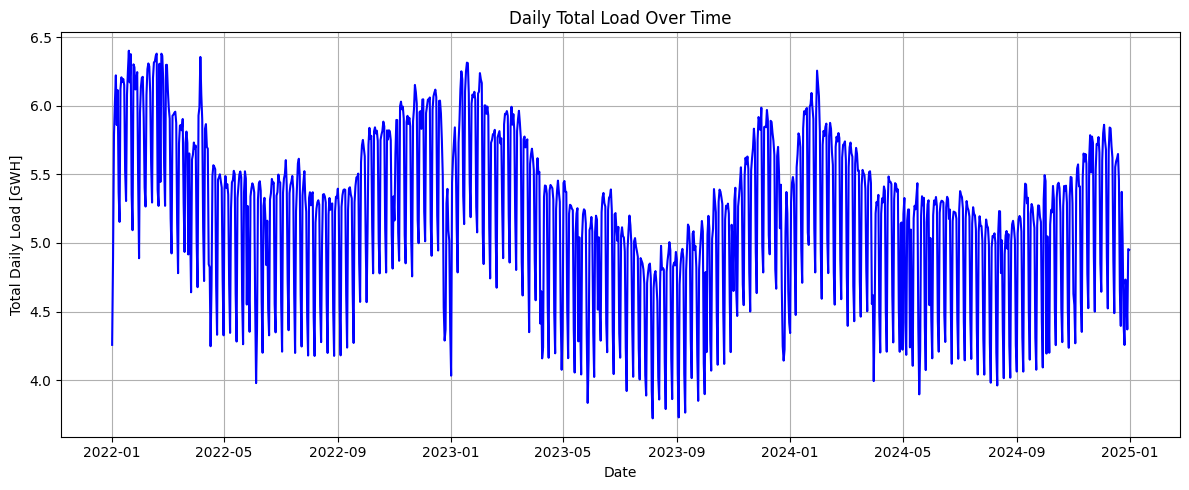

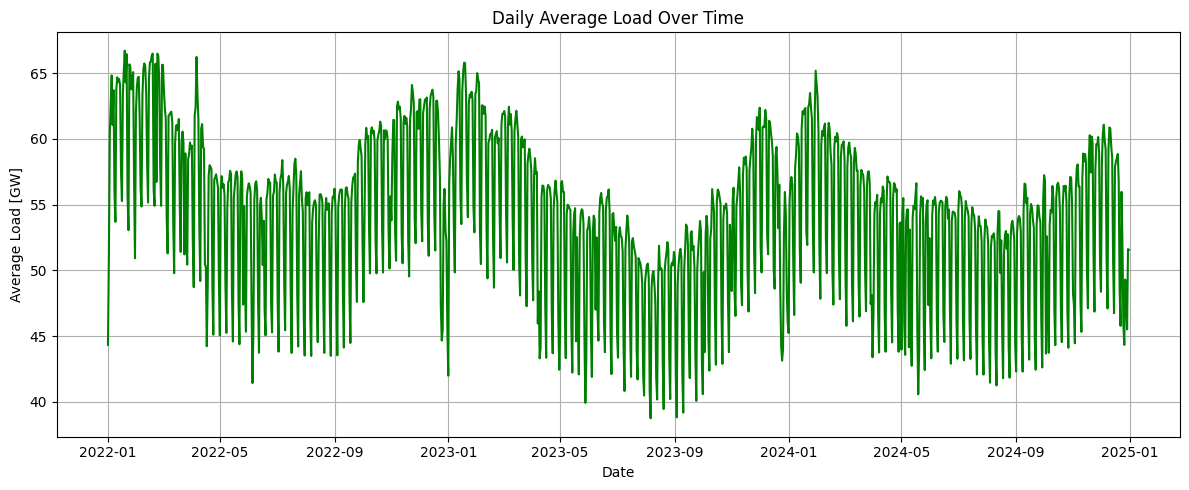

C:\Users\lavee\AppData\Local\Temp\ipykernel_25068\2954848304.py:65: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_load_sum = df['load'].resample('M').sum()/1000  # sum per month
C:\Users\lavee\AppData\Local\Temp\ipykernel_25068\2954848304.py:66: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_load_avg = df['load'].resample('M').mean()  # average per month (optional)


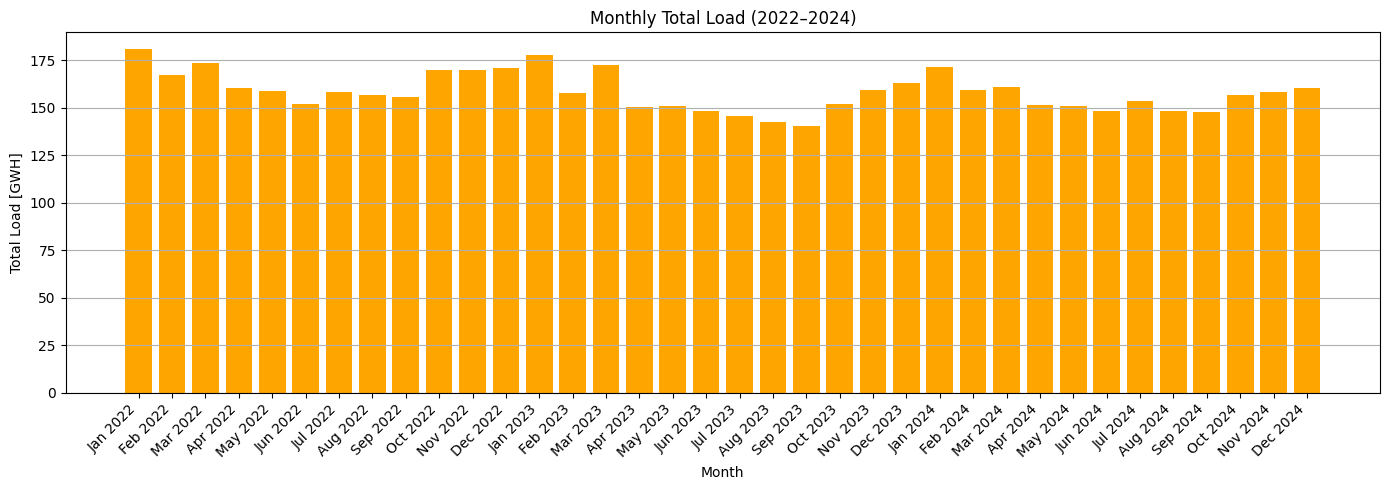

load_quantile
1      97.405078
2     112.432351
3     112.894090
4     112.472713
5     130.444498
6     147.246555
7     149.194532
8     149.783127
9     168.122455
10    183.342583
Name: da_price_eur_mwh, dtype: float64


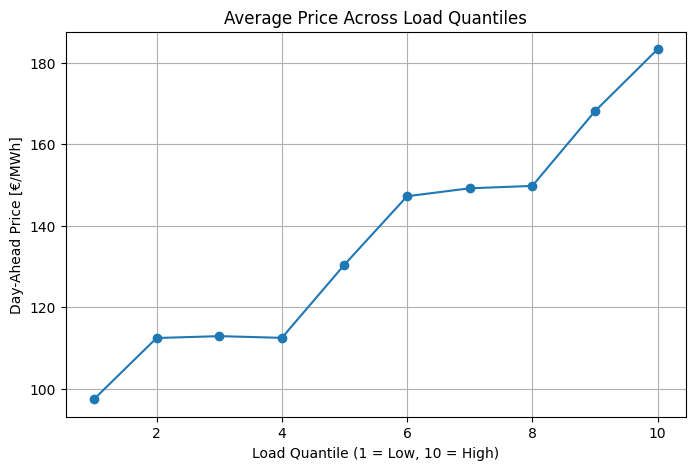

Scarcity threshold approx at load quantile 9 (~64.8 MW)


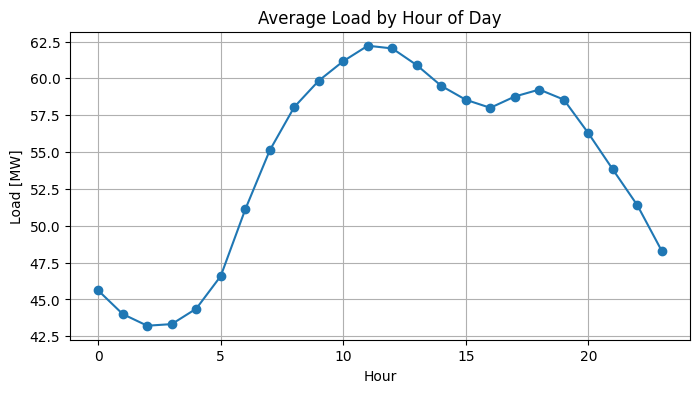

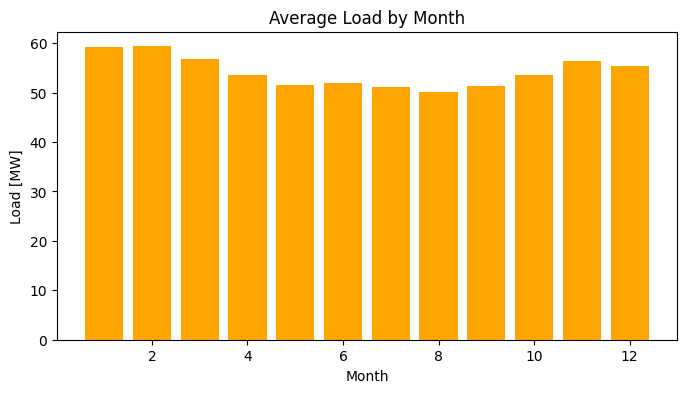

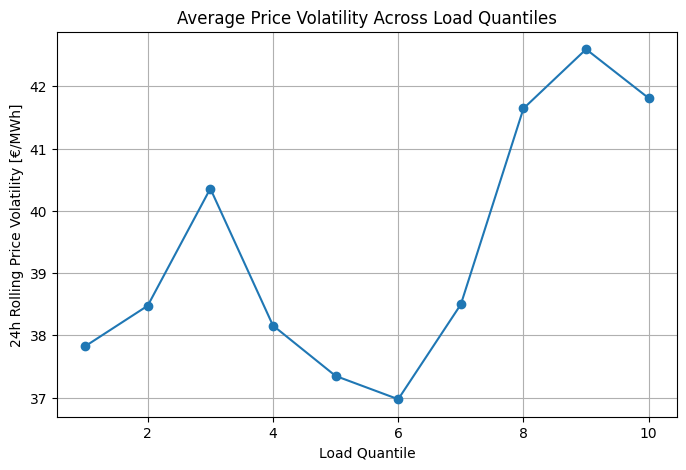

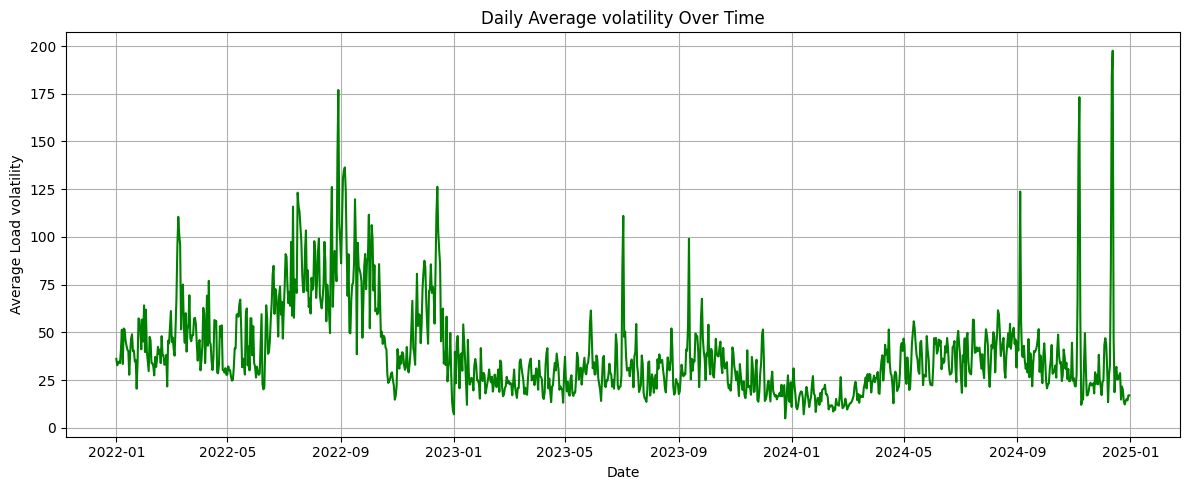

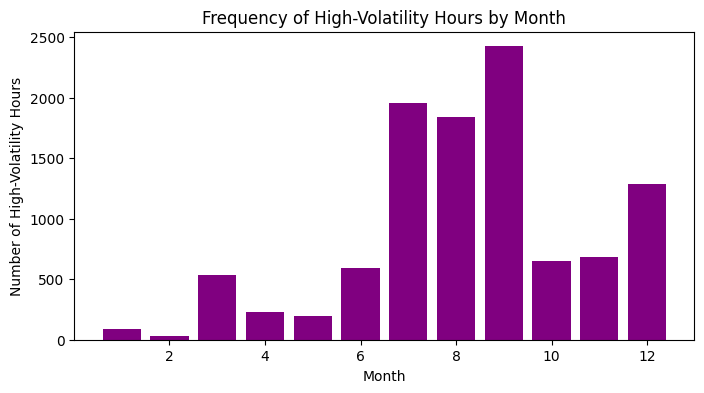

'\n## Key Insights & Recommendations\n\n- Load quantiles indicate that prices rise sharply at high loads (scarcity threshold)\n- Price volatility increases with load, especially in upper quantiles\n- Volatility is relatively uniform across hours, but seasonally high from July–September\n- High-volatility periods correspond to system tightness, critical for:\n    - Capacity planning (ensure reserves in high load months)\n    - Trading strategies (hedge or avoid high-risk periods)\n    - Operational risk management (flexibility in summer months)\n'

In [7]:
# ===============================
# Notebook: 02_report_ready.ipynb
# Consultant / Utility Level Report
# Dataset: data/final/load_price_clean.csv
# ===============================

#  Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path

base_dir = Path.cwd().parent
file= base_dir / "data"/"Final"/"load_price_clean.csv"


# ===============================
# 1 Load Data and Describe 
# ===============================
df = pd.read_csv(file)
df.rename(columns={"Price":"da_price_eur_mwh", "load":"load"}, inplace=True)
df['timestamp']=pd.to_datetime(df['timestamp'])
df.set_index('timestamp',inplace=True)
#Create hour and date columns for temporal analysis
df['hour'] = df.index.hour
df['day'] = df.index.weekday  # 0 = Monday, 6 = Sunday
df['month'] = df.index.month

# Some Basics data analytic
desc_table = df[['load','da_price_eur_mwh']].describe().T
desc_table['unit'] = ['GW', '€/MWh']  # Add units
desc_table = desc_table[['unit','mean','std','min','25%','50%','75%','max']]

print("### Descriptive Statistics (Load & Price)")
print(desc_table)


# 2️⃣ Resampled Daily & Monthly Load Plots

# Daily sum of load
daily_load_sum = df['load'].resample('D').sum()/1000
plt.figure(figsize=(12,5))
plt.plot(daily_load_sum.index, daily_load_sum.values, color='blue')
plt.title("Daily Total Load Over Time")
plt.xlabel("Date")
plt.ylabel("Total Daily Load [GWH]")
plt.grid(True)
plt.tight_layout()
plt.show()

# Daily average load
daily_load_avg = df['load'].resample('D').mean()
plt.figure(figsize=(12,5))
plt.plot(daily_load_avg.index, daily_load_avg.values, color='green')
plt.title("Daily Average Load Over Time")
plt.xlabel("Date")
plt.ylabel("Average Load [GW]")
plt.grid(True)
plt.tight_layout()
plt.show()

# Monthly sum of load
monthly_load_sum = df['load'].resample('M').sum()/1000  # sum per month
monthly_load_avg = df['load'].resample('M').mean()  # average per month (optional)

# Creating monthly lables x-axis: 'Jan 2022', 'Feb 2022', etc.
monthly_labels = [date.strftime('%b %Y') for date in monthly_load_sum.index]

plt.figure(figsize=(14,5))
plt.bar(monthly_labels, monthly_load_sum.values, color='orange')
plt.title("Monthly Total Load (2022–2024)")
plt.xlabel("Month")
plt.ylabel("Total Load [GWH]")
plt.xticks(rotation=45, ha='right')  # rotating x-axis labels for readability
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# ===============================
# 3️⃣ Load–Price Relationship
# ===============================

## Markdown:
"""
## Load–Price Relationship

We first analyze how electricity prices behave at different load levels.
Load quantiles are created to summarize system tightness from low to high demand.
"""

# Create load quantiles (10 deciles)
df["load_quantile"] = pd.qcut(df["load"], 10, labels=False) + 1

# Average price per load quantile
avg_price_per_quantile = df.groupby("load_quantile")["da_price_eur_mwh"].mean()
print(avg_price_per_quantile)

# Plot
plt.figure(figsize=(8,5))
plt.plot(avg_price_per_quantile.index, avg_price_per_quantile.values, marker='o')
plt.title("Average Price Across Load Quantiles")
plt.xlabel("Load Quantile (1 = Low, 10 = High)")
plt.ylabel("Day-Ahead Price [€/MWh]")
plt.grid(True)
plt.show()

# ===============================
# 4️⃣ Scarcity Threshold Detection
# ===============================

## Markdown:
"""
## Scarcity Threshold Detection

We identify load levels where price jumps sharply. These indicate scarcity thresholds
where the system is tight and market prices react strongly.
"""

# Simple approach: difference between quantile averages
price_diff = avg_price_per_quantile.diff()
scarcity_quantile = price_diff.idxmax()
scarcity_load = df[df["load_quantile"]==scarcity_quantile]["load"].mean()

print(f"Scarcity threshold approx at load quantile {scarcity_quantile} (~{scarcity_load:.1f} MW)")

# ===============================
# 5️⃣ Temporal Load Patterns
# ===============================

## Markdown:
"""
## Temporal Load Patterns

We examine when high load occurs:
- Hourly distribution
- Monthly distribution (seasonal patterns)
"""

# Average load by hour
avg_load_hour = df.groupby("hour")["load"].mean()
plt.figure(figsize=(8,4))
plt.plot(avg_load_hour.index, avg_load_hour.values, marker='o')
plt.title("Average Load by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Load [MW]")
plt.grid(True)
plt.show()

# Average load by month
avg_load_month = df.groupby("month")["load"].mean()
plt.figure(figsize=(8,4))
plt.bar(avg_load_month.index, avg_load_month.values, color='orange')
plt.title("Average Load by Month")
plt.xlabel("Month")
plt.ylabel("Load [MW]")
plt.show()

# ===============================
# 6️⃣ Volatility & Risk Regimes
# ===============================

## Markdown:
"""
## Price Volatility & Risk Regimes

We define a rolling 24h volatility to understand market risk dynamics.
"""

# 24h rolling volatility
df["price_volatility_24h"] = df["da_price_eur_mwh"].rolling(96).std()

# Volatility per load quantile
volatility_per_quantile = df.groupby("load_quantile")["price_volatility_24h"].mean()

plt.figure(figsize=(8,5))
plt.plot(volatility_per_quantile.index, volatility_per_quantile.values, marker='o')
plt.title("Average Price Volatility Across Load Quantiles")
plt.xlabel("Load Quantile")
plt.ylabel("24h Rolling Price Volatility [€/MWh]")
plt.grid(True)
plt.show()

# Seasonal volatility: monthly average
volatility_daily = df["price_volatility_24h"].resample('D').mean()
plt.figure(figsize=(12,5))
plt.plot(volatility_daily.index, volatility_daily.values, color='green')
plt.title("Daily Average volatility Over Time")
plt.xlabel("Date")
plt.ylabel("Average Load volatility")
plt.grid(True)
plt.tight_layout()
plt.show()

# ===============================
# 7️⃣ Typical High-Volatility Periods
# ===============================

## Markdown:
"""
## Typical High-Volatility Periods

Identify periods where price volatility is high (e.g., top 10% of rolling volatility)
to highlight stress periods for trading and operational planning.
"""

# Define high volatility threshold (top 10%)
high_vol_threshold = df["price_volatility_24h"].quantile(0.9)
high_vol_df = df[df["price_volatility_24h"] >= high_vol_threshold]

# Count by month (seasonal insight)
high_vol_by_month = high_vol_df.groupby("month")["price_volatility_24h"].count()
plt.figure(figsize=(8,4))
plt.bar(high_vol_by_month.index, high_vol_by_month.values, color='purple')
plt.title("Frequency of High-Volatility Hours by Month")
plt.xlabel("Month")
plt.ylabel("Number of High-Volatility Hours")
plt.show()

# ===============================
# 8️⃣ Key Insights / Recommendations
# ===============================

## Markdown:
"""
## Key Insights & Recommendations

- Load quantiles indicate that prices rise sharply at high loads (scarcity threshold)
- Price volatility increases with load, especially in upper quantiles
- Volatility is relatively uniform across hours, but seasonally high from July–September
- High-volatility periods correspond to system tightness, critical for:
    - Capacity planning (ensure reserves in high load months)
    - Trading strategies (hedge or avoid high-risk periods)
    - Operational risk management (flexibility in summer months)
"""
